# 2.Marketing_Case-ELVT-Build

# H2O

In [48]:
%matplotlib inline

In [49]:
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
import pandas_profiling
import seaborn as sns
import numpy as np
from collections import Counter
import pickle

import pprint
import operator

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

from tabulate import tabulate

In [50]:
FILE = 'marketing_training_cleaned.csv'
TEST_DF_FILE = './marketing_test.pkl'
MODEL_FILE = 'marketing_model'
data = pd.read_csv(FILE)

In [51]:
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.101-b13, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\gsaez\AppData\Local\Temp\tmp_xbabv83
  JVM stdout: C:\Users\gsaez\AppData\Local\Temp\tmp_xbabv83\h2o_gsaez_started_from_python.out
  JVM stderr: C:\Users\gsaez\AppData\Local\Temp\tmp_xbabv83\h2o_gsaez_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,4 months and 13 days !!!
H2O cluster name:,H2O_from_python_gsaez_3n68dh
H2O cluster total nodes:,1
H2O cluster free memory:,247.5 Mb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [52]:
mrk = h2o.H2OFrame(data)
mrk.describe()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:7380
Cols:21




,cons.conf.idx,cons.price.idx,contact,day_of_week,default,emp.var.rate,euribor3m,housing,loan,marital,month,nr.employed,poutcome,profession,responded,schooling,campaign1,custAge1,pastEmail1,pcontacted_pdays,pContacted_previous
type,real,real,enum,enum,enum,real,real,enum,enum,enum,enum,real,enum,enum,enum,enum,int,int,enum,enum,enum
mins,-50.8,92.201,,,,-3.4,0.634,,,,,4963.6,,,,,1.0,18.0,,,
mean,-40.56775067750686,93.57061829268248,,,,0.048265582655826506,3.5789429539295465,,,,,5165.0473712737175,,,,,2.0264026402640316,39.80514905149058,,,
maxs,-26.9,94.767,,,,1.4,5.045,,,,,5228.1,,,,,6.0,64.0,,,
sigma,4.653732975650036,0.5791390659374276,,,,1.5697319890162231,1.7462251198691165,,,,,73.14368800240456,,,,,1.2618634459509646,8.93268712954785,,,
zeros,0,0,,,,0,0,,,,,0,,,,,0,0,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,411,0,0,0,0
0,-42.0,93.2,cellular,mon,unknown,-0.1,4.191,no,no,single,nov,5195.8,nonexistent,admin.,no,university.degree,1.0,55.0,no,True,no
1,-42.7,93.918,cellular,mon,no,1.4,4.96,no,no,married,jul,5228.1,nonexistent,blue-collar,no,other,1.0,42.0,no,True,no
2,-36.4,93.994,telephone,mon,no,1.1,4.857,no,no,married,may,5191.0,nonexistent,technician,no,high.school,1.0,42.0,no,True,no


In [53]:
categorical_variables = [] 

for variable in mrk.types.items():
    if variable[1] == 'enum':
        categorical_variables.append(variable[0])

for variable in categorical_variables:
    mrk[variable] = mrk[variable].asfactor() 
    
predictors = mrk.columns
predictors.remove('responded')
response = 'responded'


train, valid, oot = mrk.split_frame(ratios=[.8,.1], seed=25)

#save TEST df for future testing
oot[10,:].as_data_frame().to_pickle(TEST_DF_FILE)

In [54]:
def check_model(model, show_all = False):
    if show_all:
        display(model)
        
    print ("Full model cv auc:", model.auc(xval=True))
    for model_ in model.get_xval_models():
        print (model_.model_id, " training auc:",model_.auc(), " validation auc: ", model_.auc(valid=True))

## Binary model (GLM)

In [55]:
MRK_binomial = H2OGeneralizedLinearEstimator(family = "binomial", nfolds = 10)
MRK_binomial.train(y = response, x = predictors, training_frame = train)

check_model(MRK_binomial)

glm Model Build progress: |███████████████████████████████████████████████| 100%
Full model cv auc: 0.79057496423364
GLM_model_python_1544807446837_1_cv_1  training auc: 0.8098792574412036  validation auc:  0.7695577989478175
GLM_model_python_1544807446837_1_cv_2  training auc: 0.8102042752339995  validation auc:  0.7709517886756693
GLM_model_python_1544807446837_1_cv_3  training auc: 0.8102383697713454  validation auc:  0.7768131450861265
GLM_model_python_1544807446837_1_cv_4  training auc: 0.8104760083155317  validation auc:  0.7767669172932331
GLM_model_python_1544807446837_1_cv_5  training auc: 0.8030755592163816  validation auc:  0.8413142090467671
GLM_model_python_1544807446837_1_cv_6  training auc: 0.8102028690263984  validation auc:  0.7708053315412187
GLM_model_python_1544807446837_1_cv_7  training auc: 0.8013541925512361  validation auc:  0.8472474289171203
GLM_model_python_1544807446837_1_cv_8  training auc: 0.8048669675180881  validation auc:  0.8119625055795269
GLM_model_p

In [56]:
MRK_binomial_pred = MRK_binomial.predict(oot)

MRK_binomial_pred.cbind(oot['responded'])

glm prediction progress: |████████████████████████████████████████████████| 100%


predict,no,yes,responded
no,0.971928,0.028072,no
no,0.848528,0.151472,no
no,0.967886,0.0321143,no
no,0.955439,0.0445614,no
no,0.872358,0.127642,no
no,0.946033,0.0539668,no
no,0.9702,0.0297996,no
no,0.958961,0.0410386,no
no,0.924152,0.0758479,no
no,0.975278,0.0247217,no


## Random Forest (RF)

In [57]:
MRK_RF = H2ORandomForestEstimator(nfolds = 10)
MRK_RF.train(y = response, x = predictors, training_frame = train, validation_frame = valid)

check_model(MRK_RF)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Full model cv auc: 0.7687563419583968
DRF_model_python_1544807446837_35_cv_1  training auc: 0.7482179342294993  validation auc:  0.7875705375705375
DRF_model_python_1544807446837_35_cv_2  training auc: 0.7481316644304781  validation auc:  0.7638147432985006
DRF_model_python_1544807446837_35_cv_3  training auc: 0.7607928601816347  validation auc:  0.7328610603290676
DRF_model_python_1544807446837_35_cv_4  training auc: 0.7484443533510965  validation auc:  0.7840071854416704
DRF_model_python_1544807446837_35_cv_5  training auc: 0.7586555368878924  validation auc:  0.788454352970482
DRF_model_python_1544807446837_35_cv_6  training auc: 0.7631078481429401  validation auc:  0.7897828863346105
DRF_model_python_1544807446837_35_cv_7  training auc: 0.7657160317053545  validation auc:  0.7470352783233474
DRF_model_python_1544807446837_35_cv_8  training auc: 0.7502442128995714  validation auc:  0.7838078902229845
DR

In [58]:
MRK_RF = MRK_RF.predict(oot)
MRK_RF.cbind(oot['responded'])

drf prediction progress: |████████████████████████████████████████████████| 100%


predict,no,yes,responded
no,0.962273,0.0377273,no
yes,0.586238,0.413762,no
no,0.992169,0.00783125,no
no,0.906032,0.0939683,no
no,0.817358,0.182642,no
no,0.938971,0.0610286,no
no,0.962017,0.0379834,no
no,0.948337,0.051663,no
no,0.93675,0.06325,no
no,0.979286,0.0207143,no


## Gradient boosting machine model (GBM)

In [59]:
mrk_gbm = H2OGradientBoostingEstimator(nbins_cats = 10, seed = 25)
mrk_gbm.train(x = predictors, y= response, training_frame = train, validation_frame = valid)

#check_model(mrk_gbm)

print ("Full model cv auc:", mrk_gbm.auc())

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Full model cv auc: 0.8735059260173414


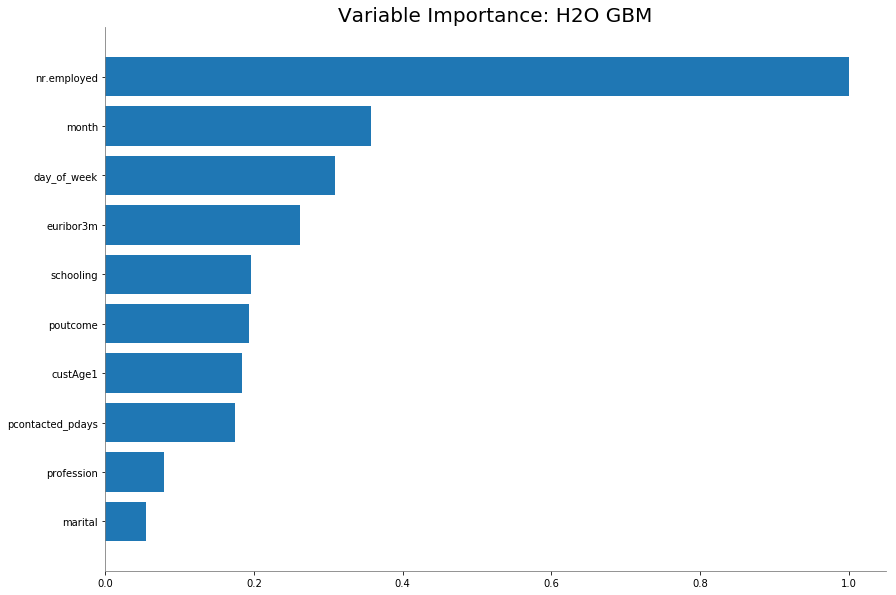

In [60]:
mrk_gbm.varimp_plot()

In [61]:
mrk_gbm_pred = mrk_gbm.predict(oot)
mrk_gbm_pred.cbind(oot['responded'])

gbm prediction progress: |████████████████████████████████████████████████| 100%


predict,no,yes,responded
no,0.974409,0.0255911,no
yes,0.663645,0.336355,no
no,0.965264,0.0347365,no
no,0.945047,0.0549526,no
no,0.827919,0.172081,no
no,0.936581,0.0634186,no
no,0.966882,0.0331177,no
no,0.931096,0.0689035,no
no,0.967808,0.032192,no
no,0.964552,0.0354482,no


## Save Model

In [62]:
# save the model
model_path = h2o.save_model(model = mrk_gbm, path = MODEL_FILE, force = True)

# Shutdown h2o

In [63]:
h2o.cluster().shutdown()

H2O session _sid_962e closed.
